In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
from diffusers import DDPMScheduler, UNet2DModel
import torch
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

/home/danya/diffusion/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
IMG_PATH = './img/img_align_celeba/img_align_celeba'
# IMG_PATH = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

In [4]:
max_timesteps = 100

noise_scheduler = DDPMScheduler(num_train_timesteps=max_timesteps,
                                beta_start=0.0001,
                                beta_end=0.1,
                                )

In [5]:
# function to load a random image from ./img/img_align_celeba/img_align_celeba
# and return it as a tensor
def load_random_img():
    img_name = random.choice(os.listdir(IMG_PATH))
    img = Image.open(os.path.join(IMG_PATH, img_name)).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    return transform(img).unsqueeze(0)

In [6]:
def denormalize(image):
    image = image.squeeze(0).permute(1, 2, 0).numpy()
    image = image * 0.5 + 0.5
    return image.clip(0, 1)

In [7]:
def plot_images(timesteps, images):
    img_height, img_width = images[0].shape[:2]
    num_images = len(timesteps)
    num_cols = min(num_images, 10)
    num_rows = (num_images + num_cols - 1) // num_cols
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(img_width * num_cols / 100, img_height * num_rows / 100))
    axs = axs.flatten() if num_rows > 1 else [axs]
    
    for i, ax in enumerate(axs):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')
            ax.set_title(f'Timestep {timesteps[i]}')
        else:
            ax.axis('off')
    plt.show()

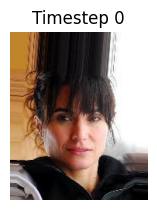

In [8]:
image = load_random_img()
plot_images([0], [denormalize(image)])

In [9]:
img_shape = image.shape
img_shape

torch.Size([1, 3, 218, 178])

In [10]:
timesteps = torch.arange(max_timesteps)
noise = torch.randn(img_shape)

In [11]:
noisy_images = noise_scheduler.add_noise(image, noise, timesteps)

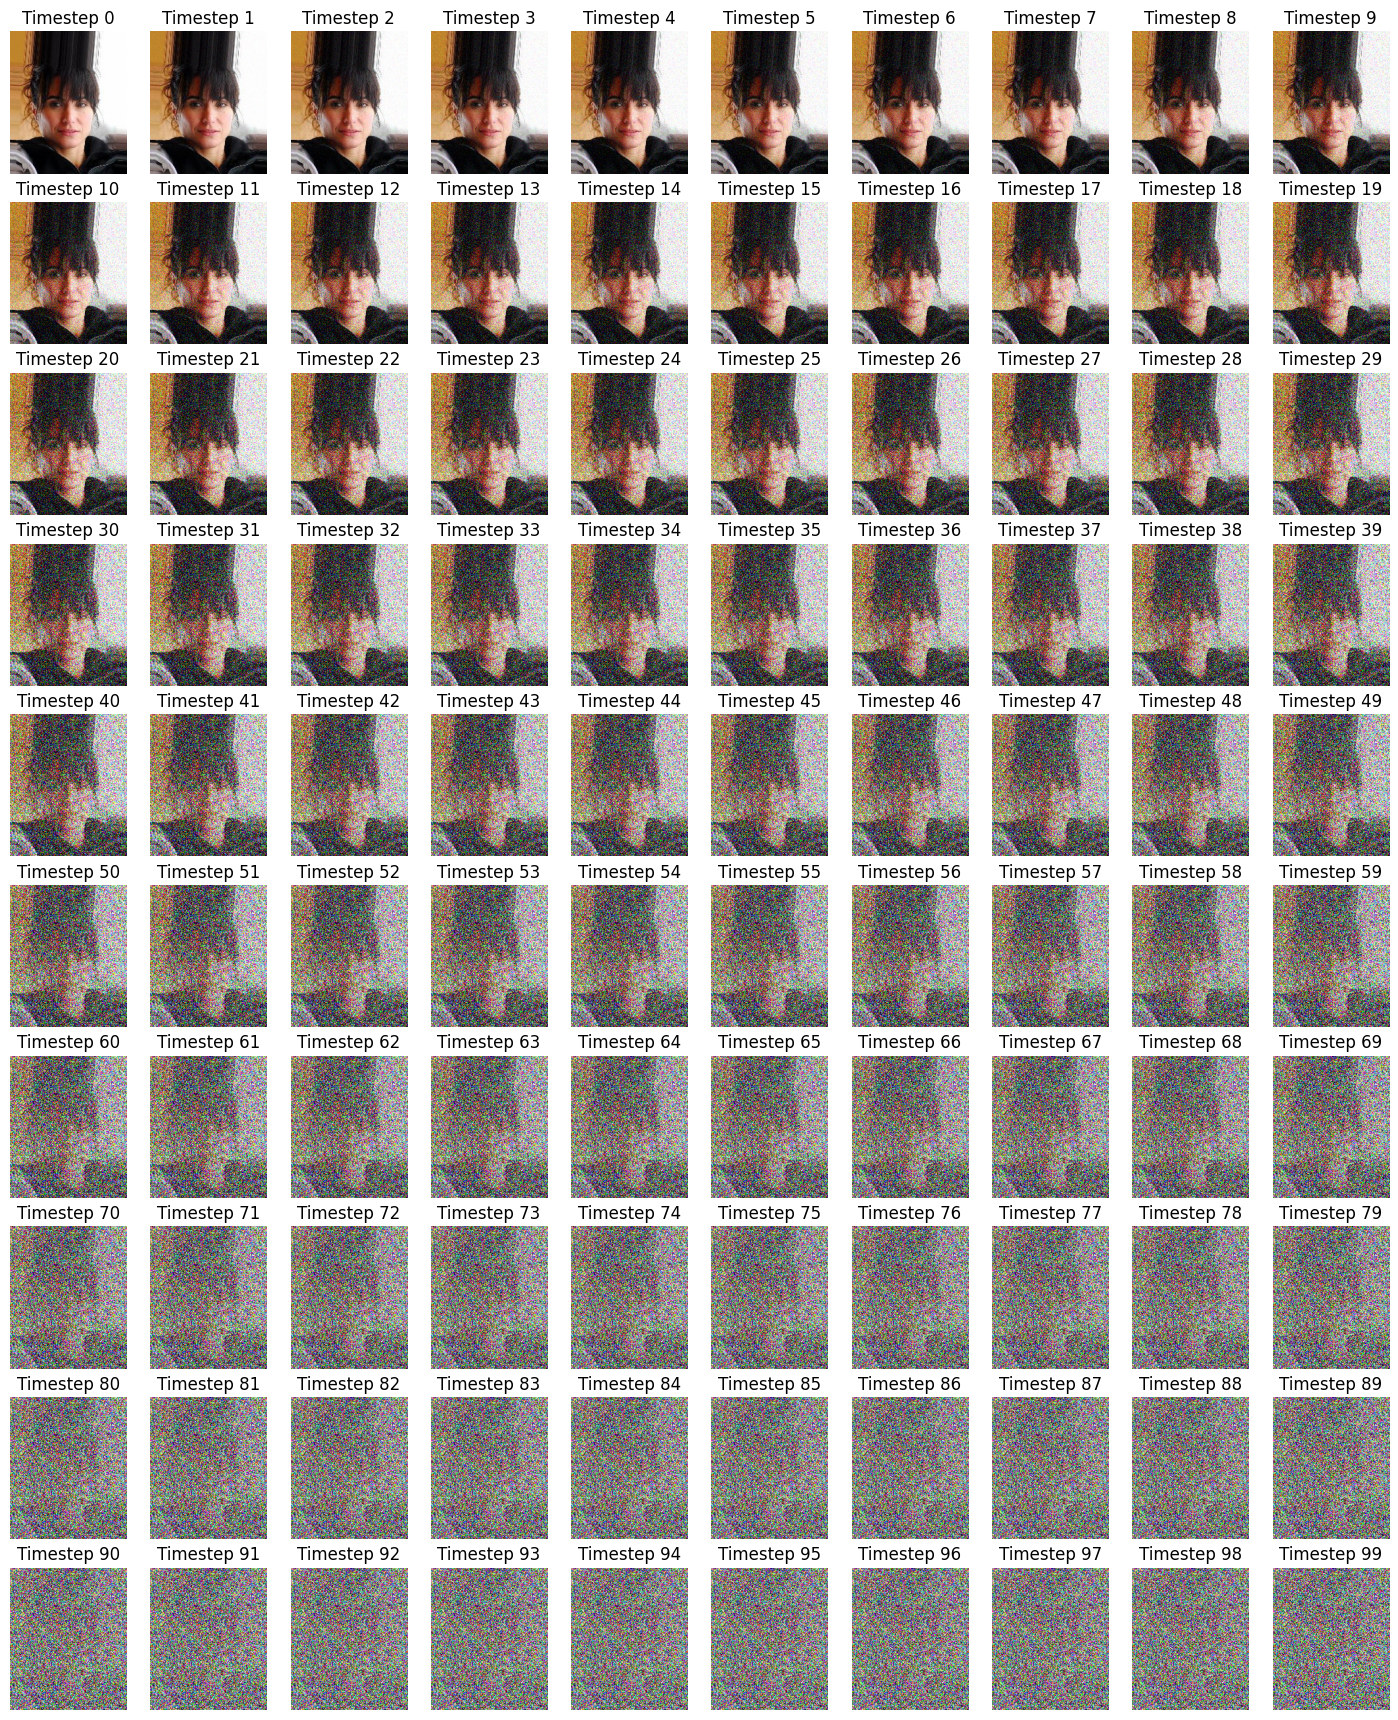

In [12]:
plot_images(timesteps, [denormalize(img) for img in noisy_images])

---

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Transform to [C, H, W] format
transform = transforms.Compose([
    transforms.ToTensor(),  # converts [H, W, C] from PIL to [C, H, W] Tensor
])

# Create a dataset
dataset = ImageFolder(
    root="./img/img_align_celeba",
    transform=transform
)

# train_size = int(0.9 * len(dataset))
# val_size = int(0.05 * len(dataset))
# test_size = len(dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# # Create dataloaders
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [15]:
# Create a custom augmentation pipeline
augment_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

def augment_images(images):
    # images is a batch [B, C, H, W]
    augmented = []
    for img in images:
        pil_img = transforms.ToPILImage()(img)     # Convert to PIL
        pil_aug = augment_transform(pil_img)       # Apply augmentation
        tensor_aug = transforms.ToTensor()(pil_aug)
        normalized_aug = (tensor_aug - 0.5) / 0.5  # Normalize to [-1, 1]
        augmented.append(normalized_aug)
    return torch.stack(augmented, dim=0)  # Return [B, C, 32, 32]

In [16]:
def train_one_epoch(unet, optimizer, loader):
    cum_loss = 0.0
    for images, _ in tqdm(loader, total=len(loader)):

        images = augment_images(images).to(device)

        img_shape = images.shape

        timesteps = torch.randint(0, max_timesteps, (img_shape[0],)).to(device)
        noise = torch.randn(img_shape).to(device)

        noisy_images = noise_scheduler.add_noise(images, noise, timesteps).to(device)

        prediction = unet(noisy_images, timesteps, return_dict=False)[0]

        loss = torch.nn.functional.mse_loss(prediction, images)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        cum_loss += loss.item()

    return cum_loss / len(loader)

In [17]:
model = UNet2DModel(
    sample_size=32,          # Input image size (32x32)
    in_channels=3,           # Input channels (RGB)
    out_channels=3,          # Output channels (RGB)
    layers_per_block=2,      # Keep it simple with 1 layer per block
    block_out_channels=(32, 64, 64, 128),  # Channel progression (lightweight)
    down_block_types=(
        "DownBlock2D",       # Standard downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",   # Attention block
    ),
    up_block_types=(
        "AttnUpBlock2D",     # Attention block
        "UpBlock2D",         # Standard upsampling block
        "UpBlock2D",
        "UpBlock2D",
    ),
).to(device)

In [18]:
max_timesteps = 1000
noise_scheduler = DDPMScheduler(num_train_timesteps=max_timesteps)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

images, _ = next(iter(dataloader))
print("Images shape:", images.shape)
images = augment_images(images).to(device)

img_shape = images.shape
print("Image shape:", img_shape)
print("Image min:", images.min().item())
print("Image max:", images.max().item())

timesteps = torch.randint(0, max_timesteps, (img_shape[0],)).to(device)
print("timesteps shape:", timesteps.shape)
noise = torch.randn(img_shape).to(device)
print("noise shape:", noise.shape)

noisy_images = noise_scheduler.add_noise(images, noise, timesteps).to(device)

prediction = model(noisy_images, timesteps, return_dict=False)[0]
print("Prediction shape:", prediction.shape)

loss = torch.nn.functional.mse_loss(prediction, images)
print("Loss:", loss.item())

loss.backward()
optimizer.step()
optimizer.zero_grad()

Images shape: torch.Size([64, 3, 218, 178])
Image shape: torch.Size([64, 3, 32, 32])
Image min: -1.0
Image max: 1.0
timesteps shape: torch.Size([64])
noise shape: torch.Size([64, 3, 32, 32])
Prediction shape: torch.Size([64, 3, 32, 32])
Loss: 0.49741649627685547


In [67]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [74]:
train_one_epoch(model, optimizer, dataloader)

100%|██████████| 3166/3166 [22:05<00:00,  2.39it/s]


0.13436401636349726

Step 0


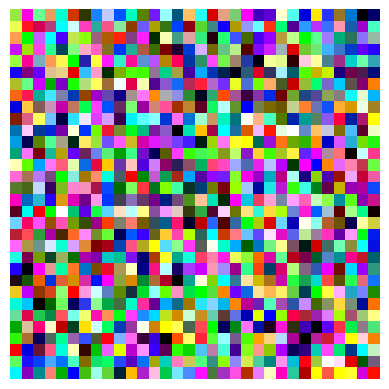

Step 100


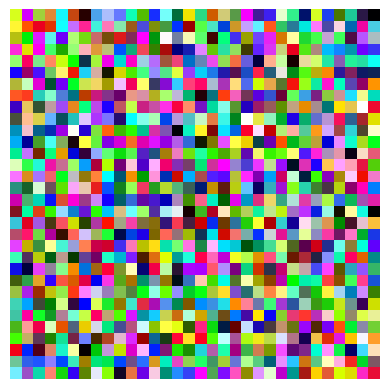

Step 200


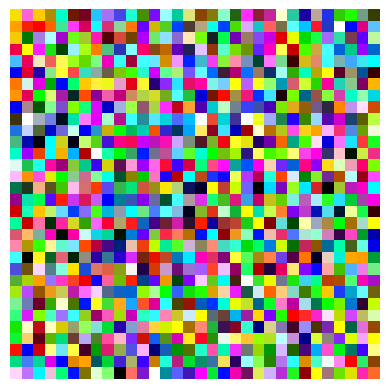

Step 300


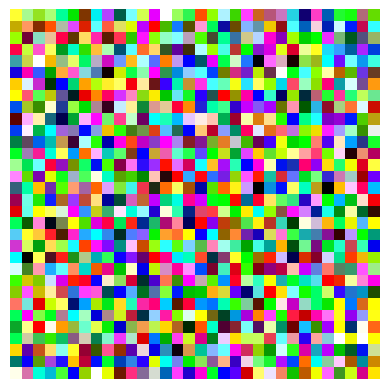

Step 400


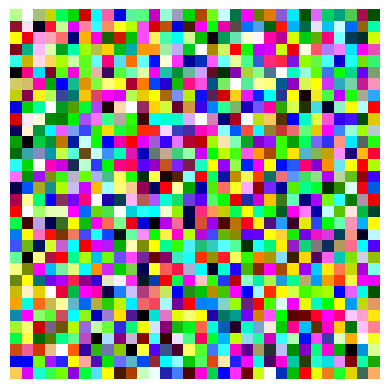

Step 500


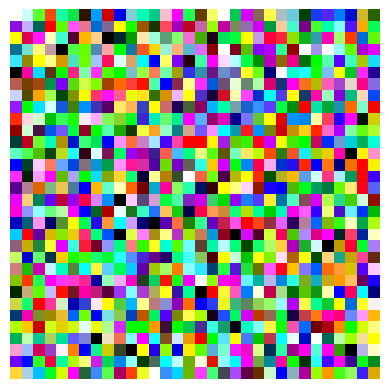

Step 600


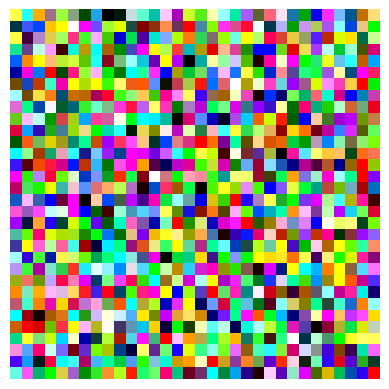

Step 700


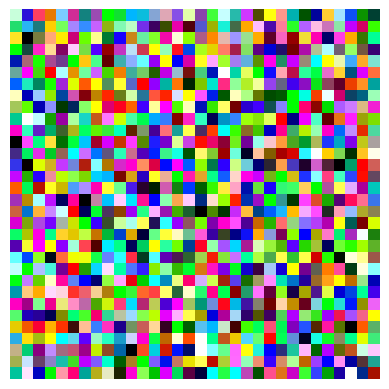

KeyboardInterrupt: 

In [23]:
target_img_shape = (3, 32, 32)

generator = torch.Generator(device=device).manual_seed(42)

image = torch.randn((1, *target_img_shape), device=device, generator=generator)
timesteps = torch.arange(0, 1000, device=device)

new_images = []

for idx, t in enumerate(timesteps):
    with torch.no_grad():
        model_output = model(image, t).sample

    image = noise_scheduler.step(model_output, t, image, generator=generator).prev_sample

    if idx % 100 == 0:
        print(f"Step {idx}")
        plt.imshow(denormalize(image.cpu()))
        plt.axis('off')
        plt.show()